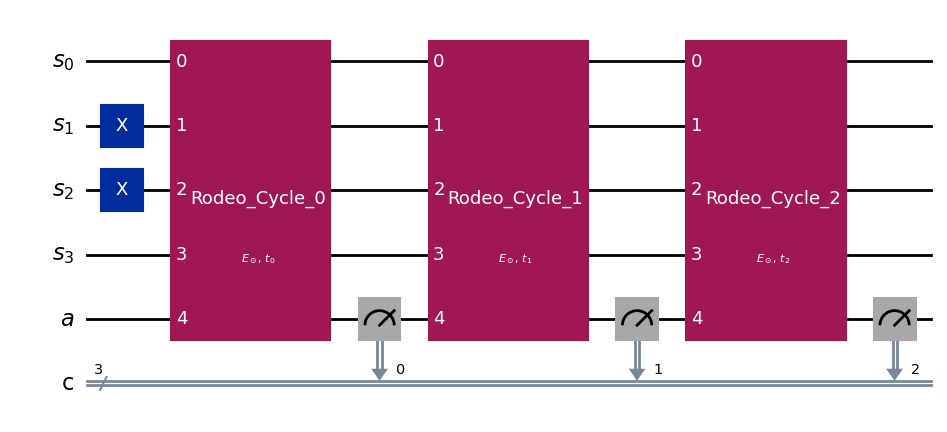

In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter

# # Define Fermi-Hubbard interaction gates for hopping and on-site terms
# Hopping Gate
def create_hopping_gate(J, delta_t):
    f_circ = QuantumCircuit(2)
    f_circ.h([0, 1])
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_circ.cx(0, 1)
    f_circ.h(1)
    f_circ.z(1)
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_gate = f_circ.to_gate(label='F_gate')
    
    g_circ = QuantumCircuit(2)
    g_circ.h([0, 1])
    g_circ.z(0)
    g_circ.s([0, 1])
    g_circ.h(1)
    g_circ.cx(0, 1)
    g_circ.h([0, 1])
    g_circ.z([0, 1])
    g_circ.s([0, 1])
    g_circ.h([0, 1])
    g_gate = g_circ.to_gate(label='G_gate')

    # The code below created a factor of 2 off
    # hop_circ = QuantumCircuit(2)
    # hop_circ.append(f_gate, [0, 1])
    # hop_circ.ry((J * delta_t) / 2, 0)
    # hop_circ.ry((-1*J * delta_t) / 2, 1)
    # hop_circ.append(g_gate, [0, 1])

    hop_circ = QuantumCircuit(2)
    hop_circ.append(f_gate, [0, 1])
    hop_circ.ry((J * delta_t), 0)
    hop_circ.ry((-1*J * delta_t), 1)
    hop_circ.append(g_gate, [0, 1])
    return hop_circ.to_gate(label=fr"A_gate_{J}")

# On-site interaction gate
def create_onsite_gate(U, delta_t):
    onsite_circ = QuantumCircuit(2)
    onsite_circ.cx(0, 1)
    onsite_circ.rz(2*U * delta_t, 1)
    onsite_circ.cx(0, 1)
    return onsite_circ.to_gate(label=fr"B_gate_{U}")

# Define the rodeo cycle
def rodeo_cycle(num_sites, J_value, U_value, t: Parameter, r, targ: Parameter):
    beta = t / r  # Parameter for rotation gates
    num_qubits = num_sites * 2  # Each site has two qubits (spin-up and spin-down)

    # Define quantum registers
    sys = QuantumRegister(num_qubits, 's')
    aux = QuantumRegister(1, 'a')
    qc = QuantumCircuit(sys, aux)

    # Apply Hadamard on the auxiliary qubit to create superposition
    qc.h(aux[0])

    # Trotter evolution within this single Rodeo cycle
    A_gate = create_hopping_gate(J=-J_value, delta_t=beta)
    # A_gate = create_hopping_gate(J=-2*J_value, delta_t=beta)
    B_gate = create_onsite_gate(U=U_value, delta_t=beta)

    qc.cz([sys[0], sys[1]], aux[0])
    for _ in range(r):
    
        # qc.cz([sys[0], sys[1]], aux[0])
        # Apply A_gate for hopping terms on nearest neighbors for spin-up qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            qc.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            qc.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        # Apply A_gate for hopping terms on nearest neighbors for spin-down qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            qc.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            qc.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        # qc.cz([sys[0], sys[1]], aux[0])

        # Add CX gates for every other system qubit
        for i in range(0, num_qubits, 4):
            qc.cx(aux[0], sys[i])  # Controlled X on selected system qubits
            if i + 2 < num_qubits:
                qc.cx(aux[0], sys[i + 2])

        # Apply B_gate for on-site interactions on each site
        for site in range(num_sites):
            spin_up_qubit = site * 2
            spin_down_qubit = site * 2 + 1
            qc.append(B_gate, [spin_up_qubit, spin_down_qubit])

        # # Add CX gates for every other system qubit again
        for i in range(0, num_qubits, 4):
            qc.cx(aux[0], sys[i])  # Controlled X on selected system qubits
            if i + 2 < num_qubits:
                qc.cx(aux[0], sys[i + 2])
        
    qc.cz([sys[0], sys[1]], aux[0])


    # Phase rotation based on the energy target and time sample
    qc.p(2*targ * t, aux[0])
    qc.h(aux[0])

    return qc

def create_super_iterations(time_sample: float, iterations: int):
    times_list = np.zeros(iterations + 1)
    
    time = time_sample
    
    for i in range(0, iterations+1):
        time /= 2  # Halve the time each iteration
        times_list[i] = time
    
    return times_list

# Define circuit parameters
num_sites = 2
J_input = 4.0
U_input = 1.0

# Initialize cycling parameters
cycles = 3
iterations = 0

# Initialize Qiskit parameters
target = Parameter(r'$E_\odot$')
time = [Parameter(fr'$t_{i}$') for i in range(cycles)]
si_time = [Parameter(fr'$st_{j}$') for j in range(cycles * iterations)]
steps = 5

# Create registers and circuit
classical = ClassicalRegister(cycles * (1 + iterations), 'c')
aux = QuantumRegister(1, 'a')
sys = QuantumRegister(num_sites * 2, 's')
circuit = QuantumCircuit(sys, aux, classical)

circuit.x([sys[1], sys[2]])

# Create circuit with alternating rodeo cycles and super iterations
classical_idx = 0
super_idx = 0 

for j in range(cycles):
    rodeo_gate = rodeo_cycle(num_sites=num_sites, J_value=J_input, U_value=U_input, t=time[j], r=steps, targ=target)
    circuit.append(rodeo_gate.to_gate(label=fr'Rodeo_Cycle_{j}'), range(num_sites * 2 + 1))
    circuit.measure(aux, classical[classical_idx])
    classical_idx += 1 

    # Add super iteration cycles with si_time
    for k in range(iterations):
        rodeo_gate_si = rodeo_cycle(num_sites=num_sites, J_value=J_input, U_value=U_input, t=si_time[super_idx], r=steps, targ=target)
        circuit.append(rodeo_gate_si.to_gate(label=fr'SI_Rodeo_Cycle_{j}_{k}'), range(num_sites * 2 + 1))
        circuit.measure(aux, classical[classical_idx])
        classical_idx += 1 
        super_idx += 1 

# Draw the circuit
circuit.draw('mpl')



In [3]:
def generate_superiteration_times(tsamples, superiterations, si_time):

    # Validate the size of si_time
    if len(si_time) < len(tsamples) * superiterations:
        raise ValueError("Insufficient si_time parameters for the given cycles and superiterations.")
    
    superiteration_parameter_binds = {}
    

    for i in range(len(tsamples)):

        superiteration_times = []
        time = tsamples[i]
        for _ in range(superiterations):
            time /= 2
            superiteration_times.append(time)
        
        for j in range(superiterations):
            si_index = i * superiterations + j
            superiteration_parameter_binds[si_time[si_index]] = superiteration_times[j]
    
    return superiteration_parameter_binds

In [5]:
from qiskit_aer.primitives import Sampler

iterations_list = np.arange(1,21,1)
cycles_list = [1,2,3,4,5]
energies_list = [-8.24621125, 2.0, 8.24621125]
gamma = 15

total_runs = len(iterations_list) * len(cycles_list)
print("Total number of runs", total_runs)

# Amount of "scrambling" of t per target energy. The more random the t the better. 
timeresamples = 10 # Resampling of times for given target energy
shots_per_same_time = 1024

data = []

# Define circuit parameters
num_sites = 2
J_input = 4.0
U_input = 1.0

energy = -8.24621125
results = []

for cycles in cycles_list:
    for iterations in iterations_list:

        # Initialize Qiskit parameters
        target = Parameter(r'$E_\odot$')
        time = [Parameter(fr'$t_{i}$') for i in range(cycles)]
        si_time = [Parameter(fr'$st_{j}$') for j in range(cycles * iterations)]
        steps = 5
                
        # Initialize circuit with registers
        classical = ClassicalRegister(cycles * (1 + iterations), 'c')
        aux = QuantumRegister(1, 'a')
        sys = QuantumRegister(num_sites * 2, 's')
        circuit = QuantumCircuit(sys, aux, classical)
        circuit.x([sys[1], sys[2]])
        
        # Create circuit with alternating rodeo cycles and super iterations
        classical_idx = 0
        super_idx = 0 

        for j in range(cycles):
            rodeo_gate = rodeo_cycle(num_sites=num_sites, J_value=J_input, U_value=U_input, t=time[j], r=steps, targ=target)
            circuit.append(rodeo_gate.to_gate(label=fr'Rodeo_Cycle_{j}'), range(num_sites * 2 + 1))
            circuit.measure(aux, classical[classical_idx])
            classical_idx += 1 

            # Add super iteration cycles with si_time
            for k in range(iterations):
                rodeo_gate_si = rodeo_cycle(num_sites=num_sites, J_value=J_input, U_value=U_input, t=si_time[super_idx], r=steps, targ=target)
                circuit.append(rodeo_gate_si.to_gate(label=fr'SI_Rodeo_Cycle_{j}_{k}'), range(num_sites * 2 + 1))
                circuit.measure(aux, classical[classical_idx])
                classical_idx += 1 
                super_idx += 1 
                    
        targ_energy = {target : energy}

        # Below is a troubleshooting line you can use to see if the code is scanning through energies properly
        print("Executing for Target Energy:", targ_energy, "with ", cycles, " cycles and ", iterations, " superiterations")

        probabilities_0 = []
        for _ in range(timeresamples):
            tsamples = ((1 / gamma) * np.random.randn(cycles)).tolist()
            time_parameters = dict(zip(time, tsamples))
            superiteration_parameters = generate_superiteration_times(tsamples, superiterations=iterations, si_time=si_time)

            # Assigns target energy and time values to parameters
            circuit1 = circuit.assign_parameters(time_parameters, inplace =False)
            circuit2 = circuit1.assign_parameters(targ_energy, inplace = False)
            circuit3 = circuit2.assign_parameters(superiteration_parameters, inplace = False)
            
            # Runs simulation of circuit with values
            sampler = Sampler()
            job = sampler.run(circuit3)
            job.result()
            quasi_dists = job.result().quasi_dists
            
            # Simulate circuit
            sampler = Sampler()
            result = sampler.run(circuit3).result()
            quasi_dists = result.quasi_dists
            
            # Extract probability of 0 bitcount
            for dist in quasi_dists:
                probabilities_0.append(dist.get(0, 0)) 

        # Average probability of 0 bitcount
        avg_prob_0 = np.mean(probabilities_0)

        # Store result for this configuration
        results.append({'cycles': cycles, 'iterations': iterations, 'avg_prob_0': avg_prob_0})

        

Total number of runs 100
Executing for Target Energy: {Parameter($E_\odot$): -8.24621125} with  1  cycles and  1  superiterations
Executing for Target Energy: {Parameter($E_\odot$): -8.24621125} with  1  cycles and  2  superiterations
Executing for Target Energy: {Parameter($E_\odot$): -8.24621125} with  1  cycles and  3  superiterations
Executing for Target Energy: {Parameter($E_\odot$): -8.24621125} with  1  cycles and  4  superiterations
Executing for Target Energy: {Parameter($E_\odot$): -8.24621125} with  1  cycles and  5  superiterations
Executing for Target Energy: {Parameter($E_\odot$): -8.24621125} with  1  cycles and  6  superiterations
Executing for Target Energy: {Parameter($E_\odot$): -8.24621125} with  1  cycles and  7  superiterations
Executing for Target Energy: {Parameter($E_\odot$): -8.24621125} with  1  cycles and  8  superiterations
Executing for Target Energy: {Parameter($E_\odot$): -8.24621125} with  1  cycles and  9  superiterations
Executing for Target Energy: {

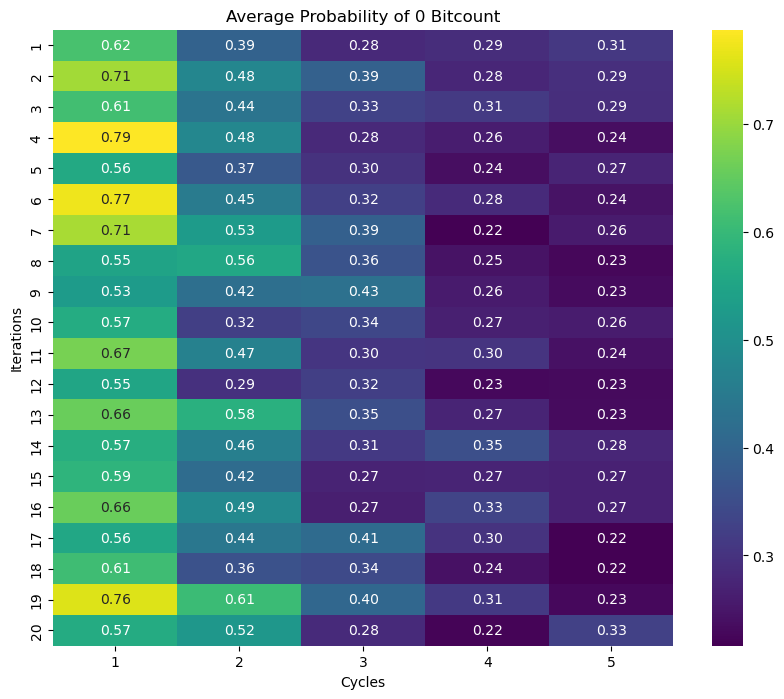

In [6]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results)
heatmap_data = df.pivot(index='iterations', columns='cycles', values='avg_prob_0')

# Plot heatmap
plt.figure(figsize=(10, 8))
plt.title('Average Probability of 0 Bitcount')
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='viridis')
plt.xlabel('Cycles')
plt.ylabel('Iterations')
plt.show()

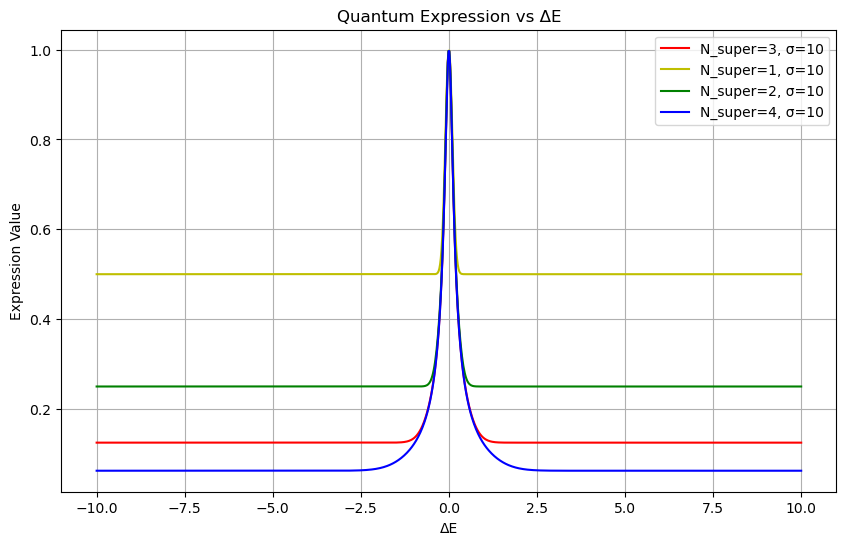

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def quantum_expression(delta_E, N_super, sigma):
    # Create the range for summation
    n_range = np.arange(0, 2**N_super + 1)
    
    # Calculate the summation term
    sum_term = np.zeros_like(delta_E)
    
    for delta_e in range(len(delta_E)):
        # Calculate the exponential term for each n
        exp_term = np.exp(-(delta_E[delta_e]**2 * sigma**2 * n_range**2) / (2**(2*N_super-1)))
        
        # Calculate the full summation
        coefficient = 1 / (2**(2*N_super-1))
        linear_term = 2**N_super - n_range
        
        sum_term[delta_e] = np.sum(coefficient * linear_term * exp_term)
    
    # Subtract the final term
    result = sum_term - 1/2**N_super
    
    return result

# Set parameters
N_super = 3  # You can adjust this
sigma = 10   # You can adjust this

# Create x-axis values (Delta E)
delta_E = np.linspace(-10, 10, 1000)

# Calculate the expression
y1 = quantum_expression(delta_E, N_super, sigma)
y2 = quantum_expression(delta_E, 1, sigma)
y3 = quantum_expression(delta_E, 2, sigma)
y4 = quantum_expression(delta_E, 4, sigma)


# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(delta_E, y1, 'r-', label=f'N_super={N_super}, σ={sigma}')
plt.plot(delta_E, y2, 'y-', label=f'N_super={1}, σ={sigma}')
plt.plot(delta_E, y3, 'g-', label=f'N_super={2}, σ={sigma}')
plt.plot(delta_E, y4, 'b-', label=f'N_super={4}, σ={sigma}')
plt.grid(True)
plt.xlabel('ΔE')
plt.ylabel('Expression Value')
plt.title('Quantum Expression vs ΔE')
plt.legend()